In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.integrate import dblquad, tplquad
from getdist import plots, MCSamples
import getdist
import torch 
import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# Models 

$$\mathcal{M}_{0}: y = A \sin(wx)$$

$$\mathcal{M}_{1}: y= ax^{2}+bx$$

$\mathcal{M}_{0}$ is not nested in $\mathcal{M}_{1}$. 

**Steps**

- Generate data using $\mathcal{M}_{0}$.
- Compute evidence analytically. 
- Compute evidence numerically. 
- Compute Bayes Factor. 
- Repeat 2-4 with the compression scheme. 

In [2]:
def model_0(xvalues: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    
    output = parameters[0]*torch.sin(parameters[1]*xvalues)
    output = output.to(torch.float64)
    return output

def model_1(xvalues: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    
    output = parameters[0]*xvalues**2 + parameters[1]*xvalues
    output = output.to(torch.float64)
    return output

In [3]:
def Z0(Y1: torch.Tensor, design_0: torch.Tensor, B1: torch.Tensor, \
       Lambda1: torch.Tensor, Sigma0: torch.Tensor, \
       mustar_0: torch.Tensor, mustar_1: torch.Tensor) -> torch.Tensor:
    
    Z0debug = False
    
    Ybarstar  = B1.t() @ (mustar_0-mustar_1)

    Psi = Lambda1+B1.t() @ design_0 @ Sigma0 @ design_0.t() @ B1
    ZZ_pdf_Psi = torch.distributions.multivariate_normal.MultivariateNormal \
    (Ybarstar, Psi)
    
    logZ0 = ZZ_pdf_Psi.log_prob(Y1).item()

    if(Z0debug):

#        print('Lambda1:',Lambda1)
#        print('Psi:',Psi)
        print('Y1:',Y1)
#        print('Ybarstar:',Ybarstar)
#        print('B1:',B1)
#        print('Sigma0:',Sigma0)
#        print('design_0:',design_0)
    
        print(-0.5*np.log(np.linalg.det(2.*np.pi*Psi)))
        print('logZ0 (new):',logZ0)

    return logZ0

In [4]:
trueModel = 0

xmin = 0.0
xmax = 1.0

torch.pi
ndata = 10
xvals = torch.linspace(xmin, xmax, ndata)

# These for illustration only:

a_param = -1.0
b_param = 2.0

# True parameters:
 
amp_param = 4.0
ang_param = 3.0

# model 0
m0_parameters = torch.tensor([amp_param, ang_param])
m0_function = model_0(xvals, m0_parameters)

# model 1
m1_parameters = torch.tensor([a_param, b_param])
m1_function = model_1(xvals, m1_parameters)

# Fiducial model in both spaces:

a_fid = -1.0
b_fid = 4.0
amp_fid = 4.0
ang_fid = 0.8

# Error and prior width:

sigma = 2.0
priorWidth = 10.0

# Fiducial mean:

fid_0_parameters = torch.tensor([amp_fid,ang_fid])
fid_1_parameters = torch.tensor([a_fid, b_fid])
mustar_0 = model_0(xvals, fid_0_parameters)
mustar_1 = model_1(xvals, fid_1_parameters)

debug = False

u = '_'
fileroot='Results/NonNested'+str(round(amp_param*10))+\
    u+str(round(ang_param*10))+u+str(round(a_fid*10))+u+str(round(b_fid*10))+\
    u+str(round(amp_fid*10))+u+str(round(ang_fid*10))+\
    u+str(round(sigma*10))+u+str(round(priorWidth*10))+u+str(ndata)

print(fileroot)

Results/NonNested40_30_-10_40_40_8_20_100_10


# Data
The data is generated using Model trueModel.

In [5]:
if(trueModel==0):
    dataTrue = model_0(xvals, m0_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
    dataTrue = dataTrue.type(torch.float64)
else:
    dataTrue = model_1(xvals, m1_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
    dataTrue = dataTrue.type(torch.float64)
    
X = dataTrue-mustar_1

print(X)
print(dataTrue)

tensor([-2.7899, -3.3367,  1.7092,  3.7359,  4.4149,  0.2651, -1.0532,  2.3889,
        -0.1827, -5.3968], dtype=torch.float64)
tensor([-2.7899, -2.9046,  2.5487,  4.9581,  5.9951,  2.1787,  1.1690,  4.8951,
         2.5827, -2.3968], dtype=torch.float64)


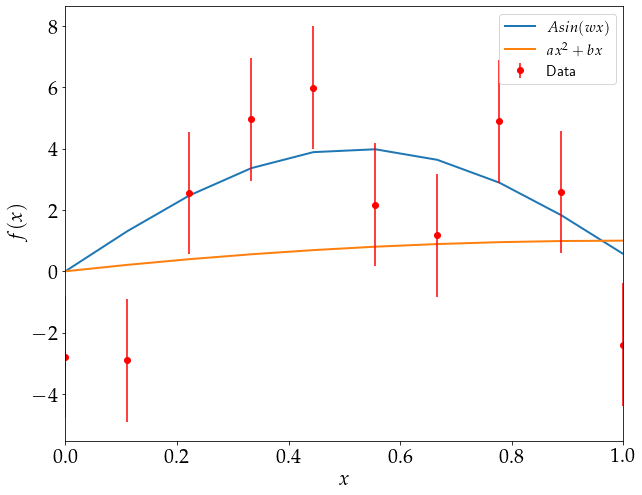

In [6]:
plt.figure(figsize = (10, 8))
plt.plot(xvals, m0_function, lw = 2, label = r'$A sin(wx)$')
plt.plot(xvals, m1_function, lw = 2, label = r'$ax^{2} + bx$')
plt.errorbar(xvals, dataTrue, yerr = sigma, fmt = 'ro', label = 'Data')
plt.xlim(xmin, xmax)
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Define all quantities 

In [7]:
C = torch.from_numpy(np.diag([sigma**2] * ndata))
C_inv = torch.from_numpy(np.diag([1/sigma**2] * ndata))

In [8]:
design_0 = torch.zeros((ndata, 2), dtype = float)
design_0[:,0] = torch.sin(ang_fid*xvals)
design_0[:,1] = xvals*amp_fid*torch.cos(ang_fid*xvals)

design_1 = torch.zeros((ndata, 2), dtype = float)
design_1[:,0] = xvals**2
design_1[:,1] = xvals

In [9]:
print(design_0)

tensor([[0.0000, 0.0000],
        [0.0888, 0.4427],
        [0.1768, 0.8749],
        [0.2635, 1.2862],
        [0.3481, 1.6666],
        [0.4300, 2.0063],
        [0.5084, 2.2963],
        [0.5828, 2.5280],
        [0.6527, 2.6938],
        [0.7174, 2.7868]], dtype=torch.float64)


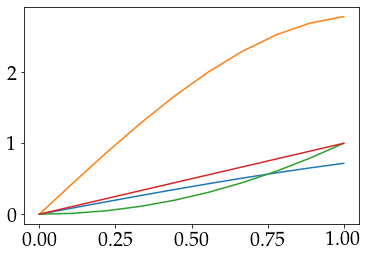

In [10]:
plt.plot(xvals,design_0[:,0])
plt.plot(xvals,design_0[:,1])
plt.plot(xvals,design_1[:,0])
plt.plot(xvals,design_1[:,1])

# Define the priors

We are assuming independent normal distribution. Multivariate normal distribution with the identity matrix as covariance. 

In [11]:
theta_fid_0 = torch.tensor([amp_fid, ang_fid], dtype = float)
theta_fid_1 = torch.tensor([a_fid, b_fid], dtype = float)

Sigma0 = priorWidth * torch.eye(2, dtype = float)
Sigma1 = priorWidth * torch.eye(2, dtype = float)

Sigma0_inv = torch.linalg.inv(Sigma0)
Sigma1_inv = torch.linalg.inv(Sigma1)

# Evidence Computation

$$ Z(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\mu},\,\mathbf{C}+\boldsymbol{\Phi}\boldsymbol{\Sigma}\boldsymbol{\Phi}^{\textrm{T}})$$

In [12]:
G0 = C + design_0 @ Sigma0 @ design_0.t()
G1 = C + design_1 @ Sigma1 @ design_1.t()

In [13]:
zero = torch.zeros(ndata)

X_pdf0 = torch.distributions.multivariate_normal.MultivariateNormal(mustar_0, G0)
X_pdf1 = torch.distributions.multivariate_normal.MultivariateNormal(mustar_1, G1)

In [14]:
ZX0 = X_pdf0.log_prob(dataTrue).item()
ZX1 = X_pdf1.log_prob(dataTrue).item()

In [15]:
print(f'The log-evidence of Model 0 is {ZX0:.4f}')
print(f'The log-evidence of Model 1 is {ZX1:.4f}')
print(f'The log-Bayes Factor between Model 0 and 1 is {ZX0 - ZX1:.4f}')

The log-evidence of Model 0 is -29.9249
The log-evidence of Model 1 is -28.0206
The log-Bayes Factor between Model 0 and 1 is -1.9043


# Compression

In [16]:
# calculate the MOPED vectors (gradient is analytical)

B0 = C_inv @ design_0
B1 = C_inv @ design_1

In [17]:
# calculate the compressed data vectors 

Y1 = B1.t() @ (dataTrue-mustar_1)

print(Y1.numpy())

[-0.78799394 -0.25989193]


# Analytical Evidence

In [18]:
Yzero1 = 0.0*Y1

In [19]:
Lambda1 = design_1.t() @ C_inv @ design_1

print(Lambda1)

Lambda1_inv = torch.linalg.inv(Lambda1)

tensor([[0.5842, 0.6944],
        [0.6944, 0.8796]], dtype=torch.float64)


In [20]:
Fisher = design_0.t() @ B1 @ Lambda1_inv @ B1.t() @ design_0
Fisher_inv = torch.linalg.inv(Fisher)

print('Fisher:',Fisher.numpy())
print('Errors:',np.sqrt(Fisher_inv[0,0]).numpy(),np.sqrt(Fisher_inv[1,1]).numpy())

Fisher: [[0.48834001 2.09333208]
 [2.09333208 9.02408025]]
Errors: 19.08309255237318 4.439238071166151


In [21]:
H1 = Lambda1+ (Lambda1 @ Sigma1 @ Lambda1.t() )
print(H1)
print(Lambda1)
print(Lambda1+B1.t() @ design_1 @ Sigma1 @ design_1.t() @ B1)
print(torch.linalg.det(Lambda1))
print(torch.linalg.det(H1))
print(torch.linalg.eig(H1))

tensor([[ 8.8202, 10.8603],
        [10.8603, 13.4396]], dtype=torch.float64)
tensor([[0.5842, 0.6944],
        [0.6944, 0.8796]], dtype=torch.float64)
tensor([[ 8.8202, 10.8603],
        [10.8603, 13.4396]], dtype=torch.float64)
tensor(0.0317, dtype=torch.float64)
tensor(0.5955, dtype=torch.float64)
torch.return_types.linalg_eig(
eigenvalues=tensor([ 0.0268+0.j, 22.2331+0.j], dtype=torch.complex128),
eigenvectors=tensor([[-0.7772+0.j, -0.6293+0.j],
        [ 0.6293+0.j, -0.7772+0.j]], dtype=torch.complex128))


In [22]:
ZY_pdf1 = torch.distributions.multivariate_normal.MultivariateNormal(Yzero1, H1)

In [23]:
ZY1 = ZY_pdf1.log_prob(Y1).item()
ZY0 = Z0(Y1, design_0, B1, Lambda1, Sigma0, mustar_0, mustar_1)

print('ZY0:',ZY0)
print('ZY1:',ZY1)

ZY0: -7.28503206786164
ZY1: -5.350619963186793


In [24]:
if(debug):
    print('design_1:',design_1)

In [25]:
print(f'X log-evidence of Model 0 is {ZX0:.4f}')
print(f'X log-evidence of Model 1 is {ZX1:.4f}')
print(f'Y log-evidence of (true)  Model 0 is {ZY0:.4f}')
print(f'Y log-evidence of (false) Model 1 is {ZY1:.4f}')
print(f'X log-Bayes Factor between Model 0 and 1 is {ZX0 - ZX1:.4f}')
print(f'Y log-Bayes Factor between Model 0 and 1 is {ZY0 - ZY1:.4f}')
print(f'The difference is {ZY0-ZY1-ZX0+ZX1:.4f}')

X log-evidence of Model 0 is -29.9249
X log-evidence of Model 1 is -28.0206
Y log-evidence of (true)  Model 0 is -7.2850
Y log-evidence of (false) Model 1 is -5.3506
X log-Bayes Factor between Model 0 and 1 is -1.9043
Y log-Bayes Factor between Model 0 and 1 is -1.9344
The difference is -0.0301


In [26]:
print(Y1.numpy())
print(H1.numpy())
print(Lambda1.numpy())
print(Sigma1.numpy())

[-0.78799394 -0.25989193]
[[ 8.82023381 10.86026006]
 [10.86026006 13.4396434 ]]
[[0.58424782 0.69444444]
 [0.69444444 0.87962963]]
[[10.  0.]
 [ 0. 10.]]


In [27]:
ntrials = 100000

Z0_X = np.zeros(ntrials)
Z1_X = np.zeros(ntrials)
Z0_Y = np.zeros(ntrials)
Z1_Y = np.zeros(ntrials)
Bayes_X = np.zeros(ntrials)
Bayes_Y = np.zeros(ntrials)
Bayes_diff = np.zeros(ntrials)

debug=False

for n in range(ntrials):
    data = model_0(xvals, m0_parameters) + \
            torch.empty(ndata).normal_(mean=0.0,std=sigma)
    data = data.type(torch.float64)
    
    Z0_X[n]  = X_pdf0.log_prob(data).item()
    Z1_X[n]  = X_pdf1.log_prob(data).item()
    
    Bayes_X[n] = Z0_X[n]-Z1_X[n]
     
    Y1   = B1.t() @ (data-mustar_1)  

    Z0_Y[n]  = Z0(Y1, design_0, B1, Lambda1, Sigma0, mustar_0, mustar_1)
    Z1_Y[n]  = ZY_pdf1.log_prob(Y1).item()
    
    Bayes_Y[n] = Z0_Y[n]-Z1_Y[n]

    Bayes_diff[n] = Bayes_Y[n] - Bayes_X[n]
    
    if(debug):
        print('Y1=',Y1.numpy())
        print('ZY0=',Z0_Y[n])
        print('ZY1=',Z1_Y[n])
        print('BX=',Z0_X[n]-Z1_X[n])
        print('BY=',Z0_Y[n]-Z1_Y[n])

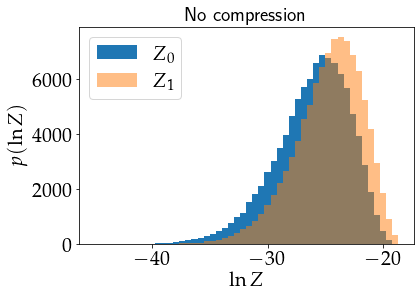

In [28]:
nbins = 50

plt.hist(Z0_X,bins=nbins, alpha=1, range=[np.min(Z1_X),np.max(Z0_X)]);
plt.hist(Z1_X,bins=nbins, alpha=0.5, range=[np.min(Z1_X),np.max(Z0_X)]);
plt.xlabel(r'$\ln Z$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.legend([r'$Z_0$',r'$Z_1$'], fontsize=20)
plt.title('No compression', fontsize=20)
plt.savefig(fileroot+'ZX01.pdf', bbox_inches='tight')

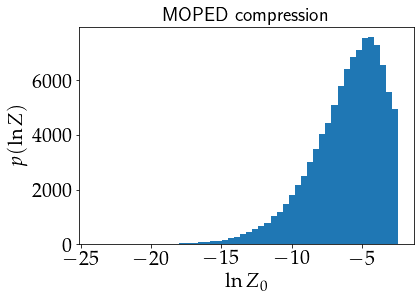

In [29]:
plt.hist(Z0_Y,bins=nbins, alpha=1, \
         range=[np.min(Z0_Y),np.max(Z0_Y)]);
plt.xlabel(r'$\ln Z_0$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'ZY0.pdf', bbox_inches='tight')

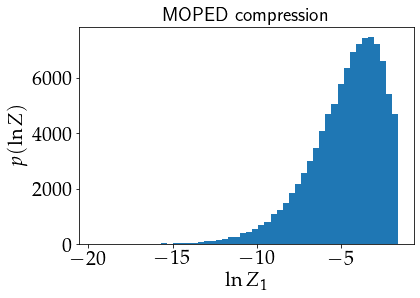

In [30]:
plt.hist(Z1_Y,bins=nbins, alpha=1, \
         range=[np.min(Z1_Y),np.max(Z1_Y)]);
plt.xlabel(r'$\ln Z_1$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'ZY1.pdf', bbox_inches='tight')

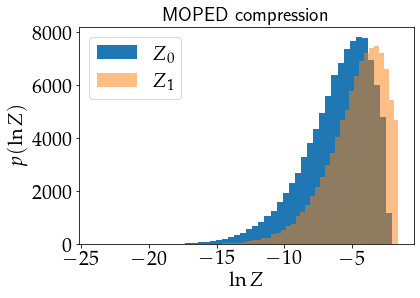

In [31]:
plt.hist(Z0_Y,bins=nbins, alpha=1, \
         range=[np.min([np.min(Z0_Y),np.min(Z1_Y)]),np.max([np.max(Z0_Y),np.max(Z1_Y)])]);
plt.hist(Z1_Y,bins=nbins, alpha=0.5);
plt.xlabel(r'$\ln Z$', fontsize=20);
plt.ylabel(r'$p(\ln Z)$', fontsize=20);
plt.legend([r'$Z_0$',r'$Z_1$'], fontsize=20)
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'ZY01.pdf', bbox_inches='tight')

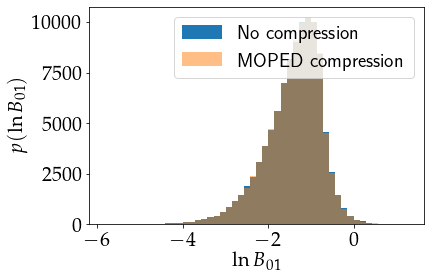

In [32]:
plotmin = np.min([np.min(Bayes_X),np.min(Bayes_Y)])
plotmax = np.max([np.max(Bayes_X),np.max(Bayes_Y)])

plt.hist(Bayes_X, alpha=1,bins=nbins, range=[plotmin,plotmax]);
plt.hist(Bayes_Y, alpha=0.5,bins=nbins, range=[plotmin,plotmax]);
plt.xlabel(r'$\ln B_{01}$', fontsize=20);
plt.ylabel(r'$p(\ln B_{01})$', fontsize=20);
plt.legend(['No compression','MOPED compression'], fontsize=20)
plt.savefig(fileroot+'BXY.pdf', bbox_inches='tight')

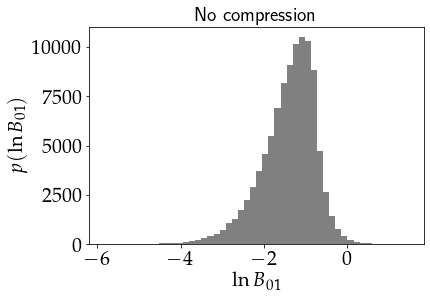

In [33]:
limitscale = np.min([np.min(Bayes_X)/np.max(Bayes_X),np.min(Bayes_Y)/np.max(Bayes_Y)])

plotmax = np.max(Bayes_X)*1.2
#plotmin = plotmax*limitscale
plotmin = np.min(Bayes_X)

plt.hist(Bayes_X, alpha=1,bins=nbins, color='gray',range=[plotmin,plotmax]);
plt.xlabel(r'$\ln B_{01}$', fontsize=20);
plt.ylabel(r'$p(\ln B_{01})$', fontsize=20);
plt.title('No compression', fontsize=20)
plt.savefig(fileroot+'BX.pdf', bbox_inches='tight')

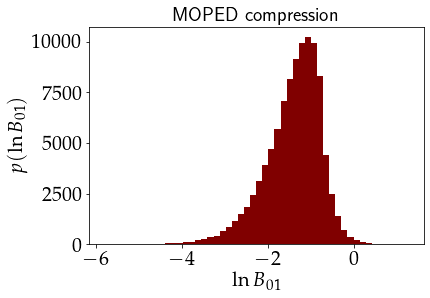

In [34]:
#plotmin = np.min(Bayes_Y)
plotmax = np.max(Bayes_Y)
plotmin = plotmax*limitscale
plotmin = np.min(Bayes_Y)

plt.hist(Bayes_Y, alpha=1,bins=nbins, color='Maroon',range=[plotmin,plotmax]);
plt.xlabel(r'$\ln B_{01}$', fontsize=20);
plt.ylabel(r'$p(\ln B_{01})$', fontsize=20);
plt.title('MOPED compression', fontsize=20)
plt.savefig(fileroot+'BY.pdf', bbox_inches='tight')

In [35]:
FractionX0 = (Bayes_X > 0).sum()/ntrials
FractionY0 = (Bayes_Y > 0).sum()/ntrials

print('Fraction X0:', FractionX0)
print('Fraction Y0:', FractionY0)

print('True model :',trueModel)

Fraction X0: 0.00413
Fraction Y0: 0.00394
True model : 0
